## 3 months

In [1]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display
import sys 
sys.path.append('../../modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from sklearn import compose, pipeline, decomposition, cross_decomposition, preprocessing, linear_model, model_selection, ensemble, feature_selection
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
import itertools
import mlxtend.feature_selection as mlxfs

# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


/home/stei509/eu_migration_forecast/notebooks/experiments/../../modules/eumf_data.py:238: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/home/stei509/eu_migration_forecast/notebooks/experiments/../../modules/eumf_data.py:279: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
            AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

In [4]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2019"
T_TEST_MAX = "2019"

cv_default = eumf_eval.BlockKFold(n_splits=8, margin=1.0)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
# n_countries = len(panel_comb_3m_macro["value"].columns)
# cv_time = model_selection.TimeSeriesSplit(test_size=4 * n_countries, n_splits=6)

In [6]:
selected_keyword_ids = ["19", "118", "28", "24", "123", "119", "39", "115", "124", "117"]


In [10]:
### TRAINING
lags_default = range(1,9)
alternate_lags_default = {
    "value": range(2,9),
    "gdp": range(2,9),
    "unempl": range(2,9),
}


model_names = [
    "3m_with_ar",
    "3m_without_ar"
]

feature_combinations = [
    ["value", "gdp", "unempl"] + selected_keyword_ids,
    ["gdp", "unempl"] + selected_keyword_ids
]


tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

# params = {
#     "randomforestregressor__max_features": [None, "sqrt", "log2"],
#     "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
#     "randomforestregressor__min_samples_split": [2, 4, 8, 16],
# }

params = {}

for i, name in enumerate(tqdm(model_names)):
    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=feature_combinations[i],
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_mae,
        cv=cv_default,
        random_iterations=20,
        # cv=cv_default,
        # dummy_encoder="drop",
    )
    estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(
        estimator, train_stacked, cv=cv_default, return_train_score=True
    )
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(
        estimator,
        test_stacked,
    )
    test_scores.append(test_score)


  0%|          | 0/2 [00:00<?, ?it/s]

/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 50%|█████     | 1/2 [00:45<00:45, 45.77s/it]/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
100%|██████████| 2/2 [01:24<00:00, 42.28s/it]


In [11]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time               score_time                   test_mae               train_mae                   test_rmse               train_rmse               test_explained_variance               train_explained_variance               test_r2_mod               train_r2_mod               test_delta_mae              train_delta_mae              
                mean    std    sem      mean     std      sem       mean    std    sem      mean    std      sem        mean    std    sem      mean     std    sem             mean           std    sem             mean            std    sem       mean     std    sem       mean      std    sem        mean       std   sem         mean       std    sem  
3m_with_ar      3.437   0.610  0.216    0.023    0.011  3.853e-03  -0.089   0.035  0.012   -0.028   0.002  6.367e-04   -0.128   0.055  0.019   -0.045    0.004  0.001           0.309          0.149  0.053           0.943           0.004  0.002     0.408    0.203  0.072     0.951     0.006  0.002      0.038      0.04  0.014       0.101      0.017  0.006
3m_without_ar   3.040   0.238  0.084    0.015    0.002  7.170e-04  -0.098   0.037  0.013   -0.030   0.002  6.462e-04   -0.140   0.054  0.019   -0.045    0.003  0.001           0.141          0.234  0.083           0.942           0.005  0.002     0.244    0.326  0.115     0.949     0.008  0.003      0.029      0.04  0.014       0.100      0.016  0.006

## 1 month

In [9]:

panel_1m = panel.resample("1M", closed="left").mean()

panel_comb_1m = eumf_data.combine_countries(panel_1m, combinations=country_combinations)


In [24]:
### TRAINING
lags_default = np.arange(1,9)*3
alternate_lags_default = {
    "value": np.arange(2,9)*3,
}


model_names = [
    "1m_with_ar",
    "1m_without_ar"
]

feature_combinations = [
    ["value"] + selected_keyword_ids,
    selected_keyword_ids
]


tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

# params = {
#     "randomforestregressor__max_features": [None, "sqrt", "log2"],
#     "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
#     "randomforestregressor__min_samples_split": [2, 4, 8, 16],
# }

params = {}

for i, name in enumerate(tqdm(model_names)):
    labeled = eumf_pipeline.prepare_data(
        panel_comb_1m,
        columns=feature_combinations[i],
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled, delta=12)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_mae,
        cv=cv_default,
        random_iterations=20,
        # cv=cv_default,
        # dummy_encoder="drop",
    )
    estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(
        estimator, train_stacked, cv=cv_default, return_train_score=True
    )
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(
        estimator,
        test_stacked,
    )
    test_scores.append(test_score)


  0%|          | 0/2 [00:00<?, ?it/s]

/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 50%|█████     | 1/2 [02:04<02:04, 124.19s/it]/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
100%|██████████| 2/2 [04:09<00:00, 124.78s/it]


In [25]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time               score_time                   test_mae               train_mae                   test_rmse               train_rmse               test_explained_variance               train_explained_variance               test_r2_mod               train_r2_mod               test_delta_mae               train_delta_mae              
                mean    std    sem      mean     std      sem       mean    std    sem      mean    std      sem        mean    std    sem      mean     std    sem             mean           std    sem             mean            std    sem       mean     std    sem       mean      std    sem        mean       std    sem         mean       std    sem  
1m_with_ar      9.967   0.648  0.229    0.017    0.002  5.600e-04  -0.116   0.039  0.014   -0.038   0.002  7.767e-04   -0.163   0.055  0.019   -0.055    0.003  0.001           0.169          0.185  0.065           0.930           0.004  0.001     0.252    0.264  0.093     0.938     0.007  0.003      0.031      0.037  0.013       0.112      0.016  0.006
1m_without_ar  10.457   0.725  0.256    0.018    0.003  1.188e-03  -0.128   0.044  0.015   -0.040   0.003  9.027e-04   -0.176   0.060  0.021   -0.057    0.004  0.001           0.062          0.274  0.097           0.925           0.003  0.001     0.119    0.353  0.125     0.933     0.007  0.003      0.020      0.033  0.012       0.110      0.015  0.005

## 1 month with sliding mean

In [59]:

panel_1m = panel.resample("1M", closed="left").mean().rolling(3).mean()

panel_comb_1m = eumf_data.combine_countries(panel_1m, combinations=country_combinations)


In [60]:
### TRAINING
lags_default = np.arange(1,9)*3
alternate_lags_default = {
    "value": np.arange(2,9)*3,
}


model_names = [
    "1m_rolling_with_ar",
    "1m_rolling_without_ar"
]

feature_combinations = [
    ["value"] + selected_keyword_ids,
    selected_keyword_ids
]


tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

# params = {
#     "randomforestregressor__max_features": [None, "sqrt", "log2"],
#     "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
#     "randomforestregressor__min_samples_split": [2, 4, 8, 16],
# }

params = {}

for i, name in enumerate(tqdm(model_names)):
    labeled = eumf_pipeline.prepare_data(
        panel_comb_1m,
        columns=feature_combinations[i],
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled, delta=12)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=ensemble.RandomForestRegressor(random_state=42),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        params=params,
        scoring=eumf_eval.scorer_mae,
        cv=cv_default,
        random_iterations=20,
        # cv=cv_default,
        # dummy_encoder="drop",
    )
    estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(
        estimator, train_stacked, cv=cv_default, return_train_score=True
    )
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(
        estimator,
        test_stacked,
    )
    test_scores.append(test_score)


  0%|          | 0/2 [00:00<?, ?it/s]

/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 50%|█████     | 1/2 [02:41<02:41, 161.57s/it]/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
100%|██████████| 2/2 [04:48<00:00, 144.32s/it]


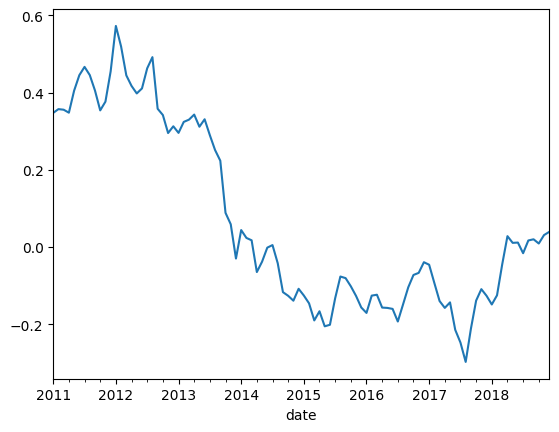

In [61]:
train_stackeds[0].y[:,"ES"].plot()
plt.show()

In [63]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time               score_time               test_mae               train_mae                   test_rmse               train_rmse                   test_explained_variance               train_explained_variance                   test_r2_mod               train_r2_mod                   test_delta_mae               train_delta_mae              
                        mean    std    sem      mean     std    sem     mean    std    sem      mean    std      sem        mean    std    sem      mean     std      sem               mean           std    sem             mean            std      sem         mean     std    sem       mean      std      sem          mean       std    sem         mean       std    sem  
1m_rolling_with_ar     13.658   1.836  0.649    0.024    0.005  0.002  -0.086   0.031  0.011   -0.020   0.001  4.147e-04   -0.126   0.049  0.017   -0.031    0.002  8.316e-04           0.313          0.188  0.066           0.973           0.001  4.372e-04     0.410    0.248  0.088     0.977     0.003  1.024e-03      0.044      0.046  0.016       0.112      0.018  0.006
1m_rolling_without_ar  10.682   1.904  0.673    0.017    0.003  0.001  -0.099   0.036  0.013   -0.022   0.002  6.077e-04   -0.143   0.052  0.018   -0.033    0.003  1.229e-03           0.089          0.418  0.148           0.970           0.002  7.671e-04     0.189    0.457  0.161     0.974     0.002  8.556e-04      0.031      0.040  0.014       0.110      0.017  0.006

In [64]:
pd.Series(estimators[0][-1].feature_importances_, index=estimators[0][0].get_feature_names_out()).sort_values(ascending=False)

value_6             4.616e-01
19_3                9.421e-02
119_9               5.294e-02
value_12            2.184e-02
119_12              2.073e-02
118_12              1.637e-02
123_12              1.443e-02
19_6                1.408e-02
119_3               1.379e-02
119_6               1.233e-02
118_18              1.182e-02
123_3               1.012e-02
19_18               9.002e-03
124_18              8.769e-03
118_24              8.703e-03
124_24              8.148e-03
118_15              7.102e-03
19_15               7.089e-03
118_9               6.715e-03
118_21              6.432e-03
123_9               6.396e-03
24_3                5.958e-03
country_GR          5.593e-03
119_15              5.248e-03
19_9                5.118e-03
123_18              5.078e-03
117_3               4.679e-03
123_24              4.593e-03
value_15            4.542e-03
119_21              4.399e-03
115_3               4.388e-03
value_9             4.372e-03
117_6               4.084e-03
19_21     